# Parts Distributor SKU classifier, part 1: Build the model

## Introduction

Electronic parts distributors like Digi-Key, Mouser etc assign their own product IDs (known as a SKU, or "stock keeping unit") to every product they sell, which is different from the "part number" that manufacturers assign to the products they make.

For example, `SN74LVC541APWR` is a part number identifying a particular IC made by Texas Instruments. Digi-Key's assigned SKU for it is `296-8521-1-ND`. Mouser calls it `595-SN74LVC541APWR`.

Once you look at a few examples, you'll notice simple patterns that allow you to (mostly) identify the source of each part number/SKU. If you wanted a computer to do that for you, regular expressions would work. _But that wouldn't be fun, would it?_

This turns out to be a great toy problem to try some machine learning algorithms on. What we want to do is use a whole lot of labeled data (where we already know the answers from some other data source) to build a model that we can then ask to categorize part numbers/SKUs that it hasn't seen before.

~~~
Me: Hey computer, what's "595-SN74LVC541APWR"?
Computer: That looks like a Mouser SKU.
Me: Ok, how about "296-8521-1-ND"?
Computer: Pretty sure it's a Digi-Key SKU.
Me: And what about "the AI is a lie"?
Computer: ...*&$*&^#$....
~~~

Since we'll be classifying sequences of characters, something like an [LSTM recurrent neural network](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) should do the trick.

We'll be using a fairly typical machine learning environment: Python, pandas, numpy, Keras and TensorFlow.

In [1]:
import pandas as pd
import numpy as np
import json
from IPython.display import Markdown, display
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import to_categorical

Using TensorFlow backend.


## Training data

Let's start with a simple labeled dataset with 2 columns:
- `partnum` is the part number/SKU string that we'll teach the model to classify
- `class` is the known classification. It has 3 possible values:
  - `0` is a manufacturer's part number
  - `1` is a Mouser SKU
  - `2` is a Digi-Key SKU

Here are the first few rows of our source file:

In [2]:
df_raw = pd.read_csv('data/mpn_mouser_digikey.csv')
class_names = ['MPN', 'Mouser SKU', 'Digi-Key SKU']
df_raw.sample(n=10)

,partnum,class
20658,478-5892-1-ND,2
19369,81-GRM21BR61E106KA3L,1
2279,ISL83485IBZ,0
4304,445-6947-6-ND,2
2395,1N4148WL2-TP,0
17903,GRM1555C1H201JA01D,0
19493,497-5923-1-ND,2
11986,MCP2542FDT-E/MFTR-ND,2
8294,RMCF0805JT200R,0
15136,296-28379-6-ND,2


It'd be good to know how many examples of each class we have, to make sure we don't run into issues with [unbalanced training sets](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set)

Let's plot how many samples of manufacturer part numbers, Mouser SKUs and Digi-Key SKUs we have in our training set.

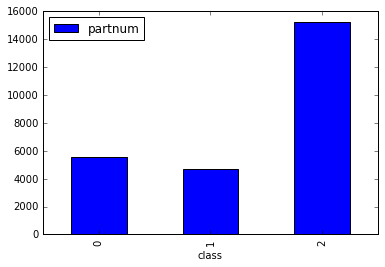

In [3]:
df_raw.groupby('class').count().plot.bar()

Looks like we have a lot more samples of Digi-Key SKUs than others. Let's drop some data to equalize the number of samples in each class, and reshuffle the rows.

In [4]:
limit_rows_per_class = int(df_raw.groupby('class').count().min())
limit_rows_per_class

4711

In [5]:
df = pd.concat(list(df_raw[df_raw['class'] == c][:limit_rows_per_class] for c in df_raw['class'].unique()))
df = df.sample(frac=1, random_state=20181203)

To [properly train the model and evaluate results](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6), we'll separate our data into 2 sets:
- train - these are the rows that the model will be learning from. (80% of the data)
- validate - use this data to evaluate the accuracy of the model. This data will NOT be used for actual training. (20% of the data)


In [6]:
# Create a new column, randomly assign each row to a dataset
np.random.seed(20181203)
df['dataset'] = np.random.choice(['train', 'val'], size=len(df), replace=True, p=[0.80, 0.20])
df.head()

,partnum,class,dataset
7218,MPMT-10K/10KDKR-ND,2,train
18646,556-ATMEGA328PB-MNR,1,train
4440,652-CRA2512FZR100ELF,1,train
3437,296-35502-1-ND,2,val
24360,649-67997-106HLF,1,val


## Prepare the inputs

The Keras LSTM layer operates on dense vectors (arrays of floats). To turn our part number strings into sequences of vectors, we'll take two steps: turn the strings into sequences of integers using a dictionary to map every character to a number, then use [Keras's "embedding" layer](https://keras.io/layers/embeddings/) to turn those into vectors. We also need to remember to terminate every sequence with a special code (we'll use a zero) to tell the model when the input stops.

In [7]:
# build the dictionary - map every unique character to an integer
unique_chars = set()
for s in df['partnum'].values:
    unique_chars |= set(c for c in s)
partnum_dict = {c: i+1 for i, c in enumerate(unique_chars)}

df['x'] = list(df['partnum'].map(lambda s: list(partnum_dict[c] for c in s)))
maxlen = max(len(pn) for pn in df['partnum'].values)
df['x'] = list(list(l) for l in sequence.pad_sequences(df['x'], maxlen=maxlen+1, padding='post'))

Here is a snippet of that dictionary:

In [8]:
list(partnum_dict.items())[:10]

[('Z', 1),
 ('G', 2),
 (' ', 4),
 ('.', 5),
 ('_', 6),
 ('A', 7),
 ('K', 8),
 ('-', 9),
 ('5', 10),
 ('8', 12)]

To tell our model which class a particular string belongs to, we'll use a technique called ["one-hot encoding"](https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b) using a helper method from Keras. Now each class will be represented by an array of mostly 0s. By the way, we'll use these same arrays when we start classifying data with our model, only then the values aren't going to be crisp 0s and 1s, but somewhere in between.

In [9]:
df['y'] = list(list(l) for l in to_categorical(df['class']))
df.head()

,partnum,class,dataset,x,y
7218,MPMT-10K/10KDKR-ND,2,train,"[32, 23, 32, 37, 9, 50, 24, 8, 15, 50, 24, 8, ...","[0.0, 0.0, 1.0]"
18646,556-ATMEGA328PB-MNR,1,train,"[10, 10, 29, 9, 7, 37, 32, 13, 2, 7, 3, 22, 12...","[0.0, 1.0, 0.0]"
4440,652-CRA2512FZR100ELF,1,train,"[29, 10, 22, 9, 16, 38, 7, 22, 10, 50, 22, 18,...","[0.0, 1.0, 0.0]"
3437,296-35502-1-ND,2,val,"[22, 46, 29, 9, 3, 10, 10, 24, 22, 9, 50, 9, 1...","[0.0, 0.0, 1.0]"
24360,649-67997-106HLF,1,val,"[29, 25, 46, 9, 29, 26, 46, 46, 26, 9, 50, 24,...","[0.0, 1.0, 0.0]"


## Build and train the model

We are now ready to build and train the model. The simple architecture of this particular network was taken from a [Keras example](https://github.com/keras-team/keras/blob/2.0.5/examples/imdb_lstm.py), and it just happened to work for our toy problem with only minor modifications, so we'll just leave it as is.

In [10]:
def d(col, ds, class_filter=None):
    if class_filter is not None:
        return list(df[(df['dataset'] == ds) & (df['class'] == class_filter)][col])
    else:
        return list(df[df['dataset'] == ds][col])            

# config
batch_size = 32

In [11]:
# build model
model = Sequential()
model.add(Embedding(len(partnum_dict)+1, 32))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(d('x', 'train'), d('y', 'train'),
          batch_size=batch_size,
          epochs=7,
          validation_data=(d('x', 'val'), d('y', 'val')))

Train...
Train on 11344 samples, validate on 2789 samples
Epoch 1/7
11344/11344 [==============================] - 14s - loss: 0.6081 - acc: 0.6560 - val_loss: 0.3809 - val_acc: 0.8200
Epoch 2/7
11344/11344 [==============================] - 12s - loss: 0.2809 - acc: 0.8876 - val_loss: 0.1270 - val_acc: 0.9577
Epoch 3/7
11344/11344 [==============================] - 12s - loss: 0.1482 - acc: 0.9517 - val_loss: 0.0805 - val_acc: 0.9745
Epoch 4/7
11344/11344 [==============================] - 12s - loss: 0.1033 - acc: 0.9679 - val_loss: 0.0655 - val_acc: 0.9806
Epoch 5/7
11344/11344 [==============================] - 12s - loss: 0.0841 - acc: 0.9715 - val_loss: 0.0580 - val_acc: 0.9796
Epoch 6/7
11344/11344 [==============================] - 12s - loss: 0.0698 - acc: 0.9772 - val_loss: 0.0476 - val_acc: 0.9857
Epoch 7/7
11344/11344 [==============================] - 12s - loss: 0.0646 - acc: 0.9790 - val_loss: 0.0420 - val_acc: 0.9849


In [12]:
score, acc = model.evaluate(d('x', 'val'), d('y', 'val'), batch_size=batch_size)
display(Markdown('### Accuracy of the model: {:.2f}%'.format(acc * 100.0)))

2789/2789 [==============================] - 0s     


### Accuracy of the model: 98.49%

That looks pretty good, but I'm actually curious as to what kind of samples were miscategorized.

## Save the model to disk

Let's try predicting samples from each class separately to get an idea of where the model gets confused.

In [13]:
res = []
for c in sorted(df['class'].unique()):
    score, acc = model.evaluate(d('x', 'val', class_filter=c), d('y', 'val', class_filter=c), batch_size=batch_size)
    res.append([class_names[c], '{:.2f}%'.format(acc*100.0)])
pd.DataFrame(res, columns=['class', 'accuracy'])

800/921 [=========================>....] - ETA: 0s

,class,accuracy
0,MPN,96.19%
1,Mouser SKU,99.26%
2,Digi-Key SKU,100.00%


Looks like the model nailed the Digi-Key SKUs, is very good with Mouser SKUs, but is misclassifying some part numbers as either Mouser or Digi-Key SKUs. Let's save the model so that we can reload it in [part 2](parts-distributor-sku-classifier-part-2-explore.ipynb) of the notebook and poke around a bit.

In [14]:
# Serialize the model architecture
with open("data/trained_model_layers.json", "w") as json_file:
    json_file.write(model.to_json())

# Serialize the model weights to HDF5
model.save_weights("data/trained_model_weights.h5")

# Serialize our part number character dictionary - we'll need it to classify strings
with open("data/char_dictionary.json", "w") as json_file:
    json.dump(partnum_dict, json_file)
    
# Finally, save our cleaned and prepared data set - we'll need it to explore the model in part 2
df.to_json("data/cleaned_training_data.json")

## Up next

In [part 2](parts-distributor-sku-classifier-part-2-explore.ipynb) of this notebook, we'll analyze the model performance and try to get a feel for how LSTM neural network works.